In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

[==================================================] 100.0% 958.5/958.4MB downloaded
Epoch 1/10
34/34 [==============================] - 10s 254ms/step - loss: 0.3665 - accuracy: 0.1138 - val_loss: 0.2953 - val_accuracy: 0.0794
Epoch 2/10
34/34 [==============================] - 9s 280ms/step - loss: 0.2653 - accuracy: 0.1017 - val_loss: 0.2600 - val_accuracy: 0.0794
Epoch 3/10
34/34 [==============================] - 9s 258ms/step - loss: 0.2131 - accuracy: 0.1017 - val_loss: 0.2350 - val_accuracy: 0.0794
Epoch 4/10
34/34 [==============================] - 8s 234ms/step - loss: 0.1773 - accuracy: 0.1017 - val_loss: 0.2275 - val_accuracy: 0.0794
Epoch 5/10
34/34 [==============================] - 9s 273ms/step - loss: 0.1531 - accuracy: 0.1017 - val_loss: 0.2159 - val_accuracy: 0.0794
Epoch 6/10
34/34 [==============================] - 8s 243ms/step - loss: 0.1334 - accuracy: 0.1017 - val_loss: 0.2126 - val_accuracy: 0.0794
Epoch 7/10
34/34 [==============================] - 8s 241ms/s

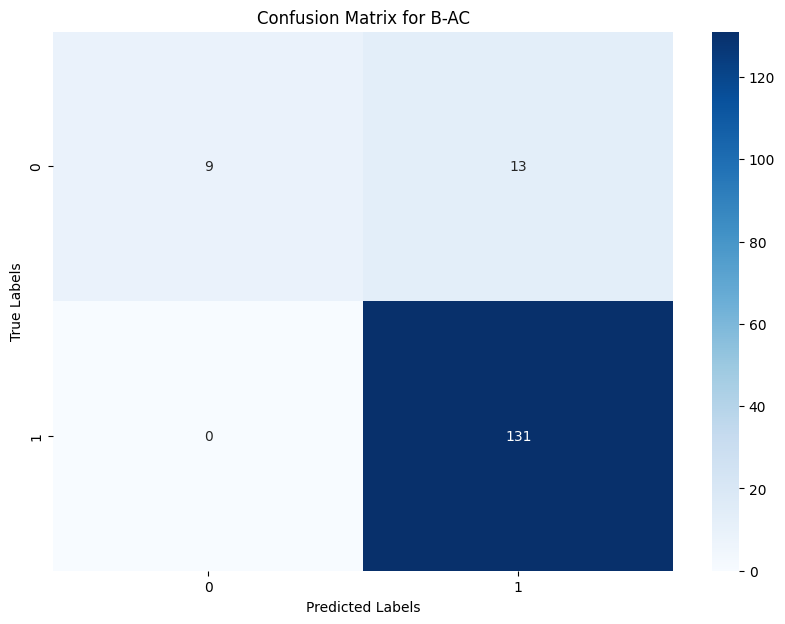

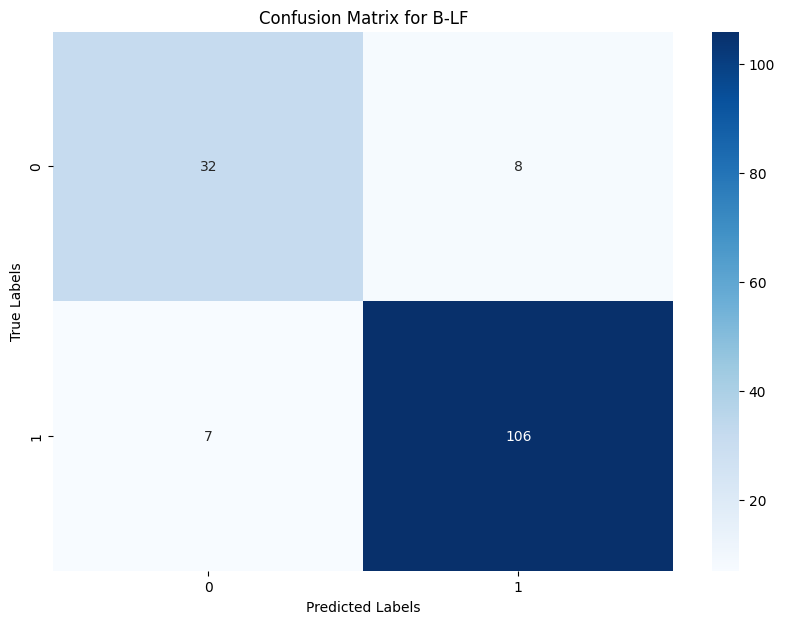

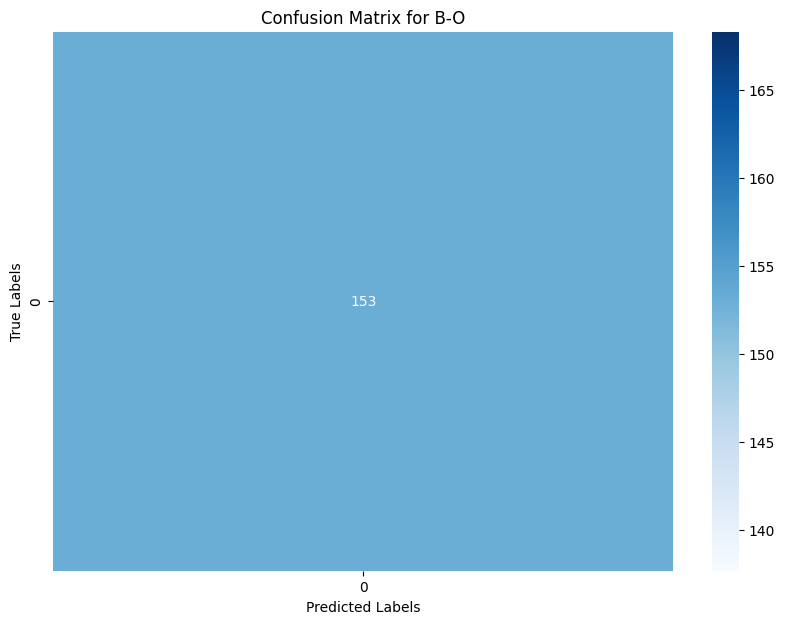

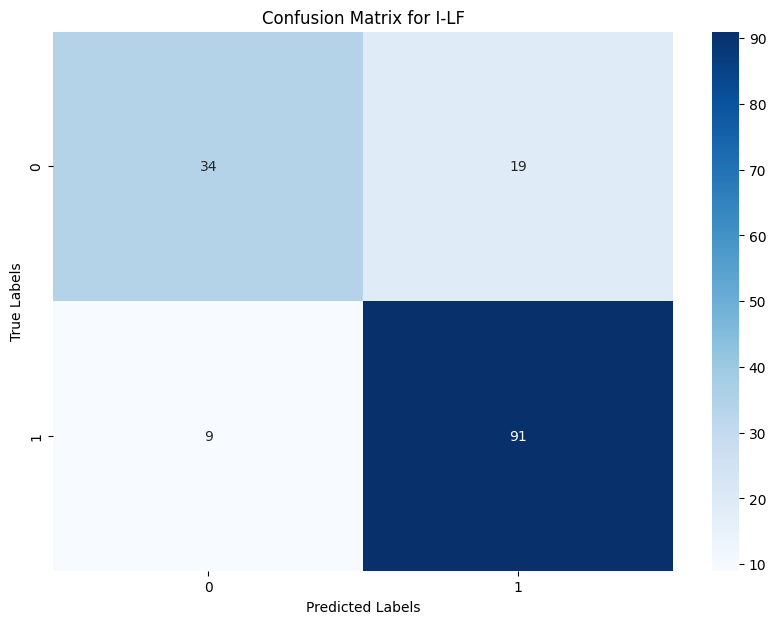

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim.downloader as api
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

# Define function for data preparation
def prepare_data(data):
    texts = [' '.join(tokens) for tokens in data['tokens']]
    return texts, data['ner_tags']

# Prepare the data
X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(val_data)
X_test, y_test = prepare_data(test_data)

# Train WordPiece tokenizer
tokenizer = Tokenizer(models.WordPiece())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
concatenated_texts = X_train + X_val + X_test
trainer = trainers.WordPieceTrainer(vocab_size=10000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
tokenizer.train_from_iterator(concatenated_texts, trainer=trainer)

# Encode the text data
X_train_enc = [tokenizer.encode(text).ids for text in X_train]
X_val_enc = [tokenizer.encode(text).ids for text in X_val]
X_test_enc = [tokenizer.encode(text).ids for text in X_test]

# Padding sequences
max_length = max(len(ids) for ids in X_train_enc + X_val_enc + X_test_enc)
X_train_pad = pad_sequences(X_train_enc, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_enc, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_enc, maxlen=max_length, padding='post')

# Load FastText model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

# Initialize embedding matrix
embedding_matrix_fasttext = np.zeros((len(tokenizer.get_vocab()) + 1, 300))

# Create the embedding matrix
for word, idx in tokenizer.get_vocab().items():
    try:
        embedding_matrix_fasttext[idx] = fasttext_model[word]
    except KeyError:
        continue

# Encode labels
encoder = MultiLabelBinarizer()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

# Build the model
model_cnn_fasttext = Sequential([
    Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=300, weights=[embedding_matrix_fasttext], input_length=max_length, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(y_train_encoded.shape[1], activation='sigmoid')
])

# Compile the model
model_cnn_fasttext.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
model_cnn_fasttext.fit(X_train_pad, y_train_encoded, epochs=10, validation_data=(X_val_pad, y_val_encoded), batch_size=32)
# Prediction on test data
y_pred_cnn_fasttext = model_cnn_fasttext.predict(X_test_pad) > 0.5

# Flatten the predictions and true labels
y_pred_flat = y_pred_cnn_fasttext.flatten()
y_test_flat = y_test_encoded.flatten()

# Calculate accuracy
accuracy = np.mean(y_pred_flat == y_test_flat)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix, f1_score

# Calculate F1Score
from sklearn.metrics import f1_score

# Calculate F1 Score for each class individually
f1_scores = f1_score(y_test_encoded, y_pred_cnn_fasttext, average=None)

# Print CNN (FastText) Classification Report
print("CNN (FastText) Classification Report:")
print(classification_report(y_test_encoded, y_pred_cnn_fasttext, target_names=encoder.classes_))

# Create and display a confusion matrix for each class
for i, class_name in enumerate(encoder.classes_):
    cm = confusion_matrix(y_test_encoded[:, i], y_pred_cnn_fasttext[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



In [8]:
print(f1_scores)

[0.95272727 0.9339207  1.         0.86666667]
